In [1]:
# Parameters
working_dir = "/import/beegfs/CMIP6/crstephenson"
sim_dir = "/import/beegfs/CMIP6/arctic-cmip6/regrid"
ref_dir = "/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid"
var_ids = "tasmax pr"
models = "GFDL-ESM4 MIROC6"
scenarios = "ssp126 ssp585"


# Common grid bias-adjustment quality control

This notebook runs various visual quality control (QC) checks on bias-adjusted, regridded CMIP6 data as maps and plots. Automated (non-visual) checks are performed separately via the qc.py script. Throughout the notebook, the same set of maps and plots will be generated for every variable/model/scenario combo received as parameters from the Prefect flow. In other words, this notebook will analyze all bias-adjusted data produced previously in the Prefect flow with a variable/model/scenario granularity. Each plot will be labeled with the corresponding variable/model/scenario information.

## Introduction to day-of-year (DOY) summaries

This QC notebook uses day-of-year (DOY) summary NetCDF files that were created earlier in the bias adjustment Prefect flow to speed up data analysis. These DOY summary files contain minimum, mean, and maximum values for each day of the year across all years, for both unadjusted model data ("sim") and adjusted model data ("adj"). This notebook explores these DOY summaries in several ways:

1. Side-by-side maps to visually compare unadjusted vs. adjusted data
1. Plots of deltas between unadjusted vs. adjusted data
1. Plots of individual pixels exhibiting a max delta at one or more days in its DOY "time" series
1. Plots of individual pixels for four random lat/lon points

First, let's import modules, set global variables, and parse arguments to be used throughout the QC notebook.

In [2]:
from datetime import datetime
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import dask
from dask_jobqueue import SLURMCluster
from config import *
from bias_adjust import generate_cmip6_fp
from generate_doy_summaries import get_sim_fps
from slurm import get_directories
from luts import sim_ref_var_lu, units_lu
import logging

# Hide seemingly unavoidable performance warnings.
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

# These arguments are passed into notebook as space-delimited strings.
var_ids = var_ids.split()
models = models.split()
scenarios = scenarios.split()

working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)

doy_summary_dir = working_dir.joinpath(
    output_dir_name, qc_dir_name, doy_summary_dir_name
)

output_dir, adj_dir = get_directories(working_dir, output_dir_name)
log_dir = "."

# Years for ERA5 reference data
ref_years = list(range(1981, 2022 + 1))

historical_years = list(range(1951, 2014 + 1))
projected_years = list(range(2015, 2100 + 1))

years = {
    "historical": historical_years,
    "ssp126": projected_years,
    "ssp245": projected_years,
    "ssp370": projected_years,
    "ssp585": projected_years,
}

## Side-by-side unadjusted (sim) vs. adjusted (adj) maps

Generate side-by-side sim vs. adj maps for two days of the year (day 1 and day 180). A set of maps will be generate for every combination of variable/model/scenario.

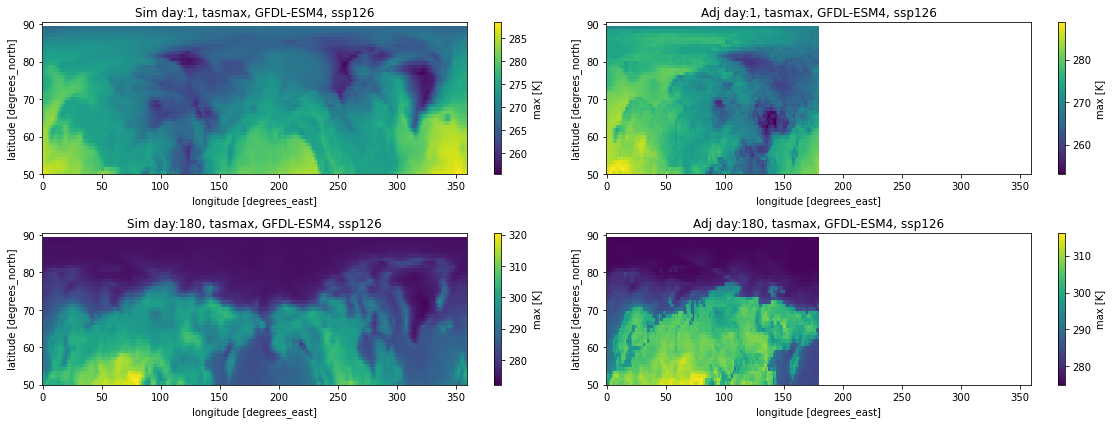

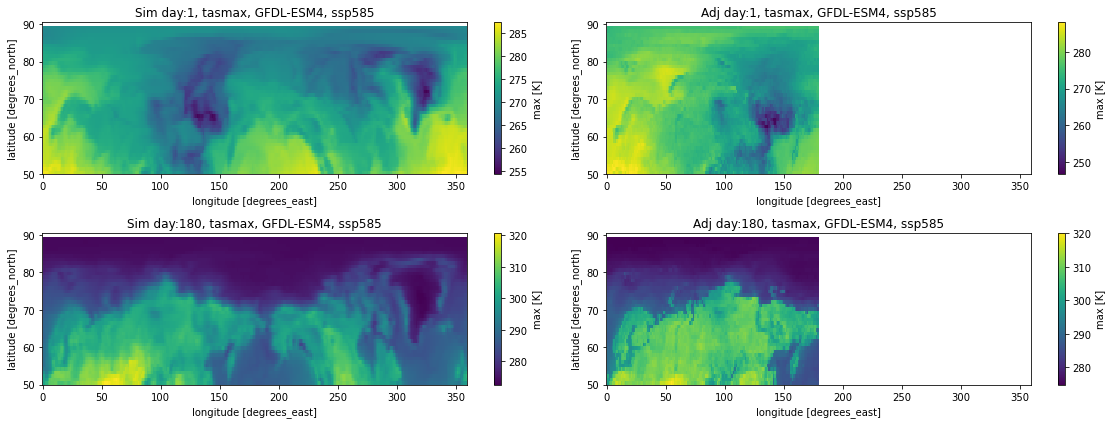

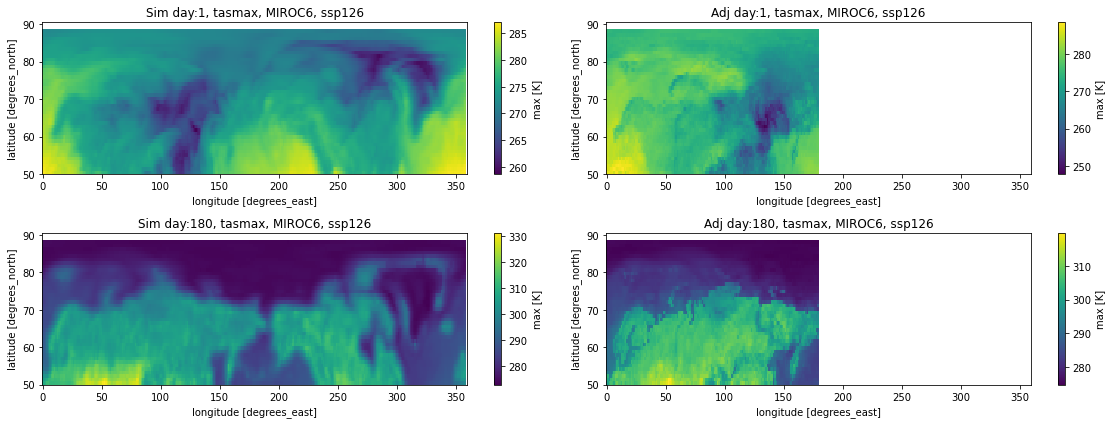

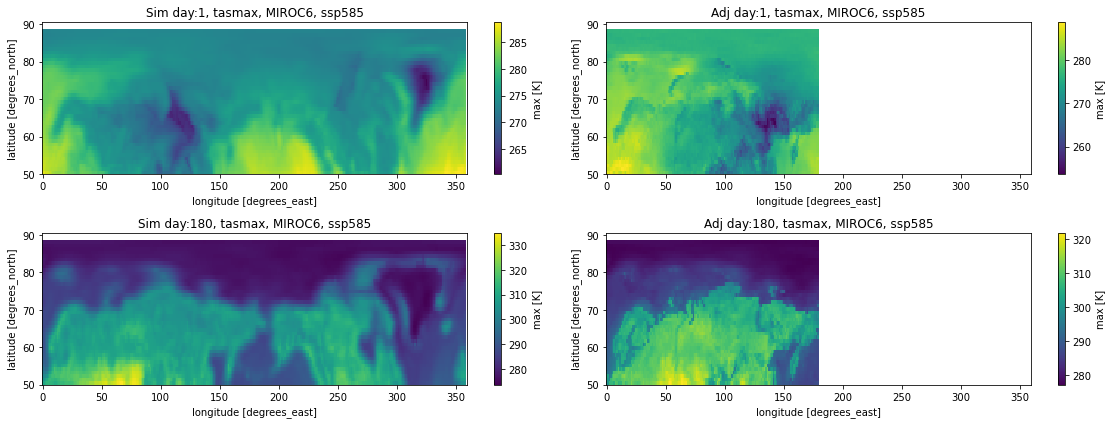

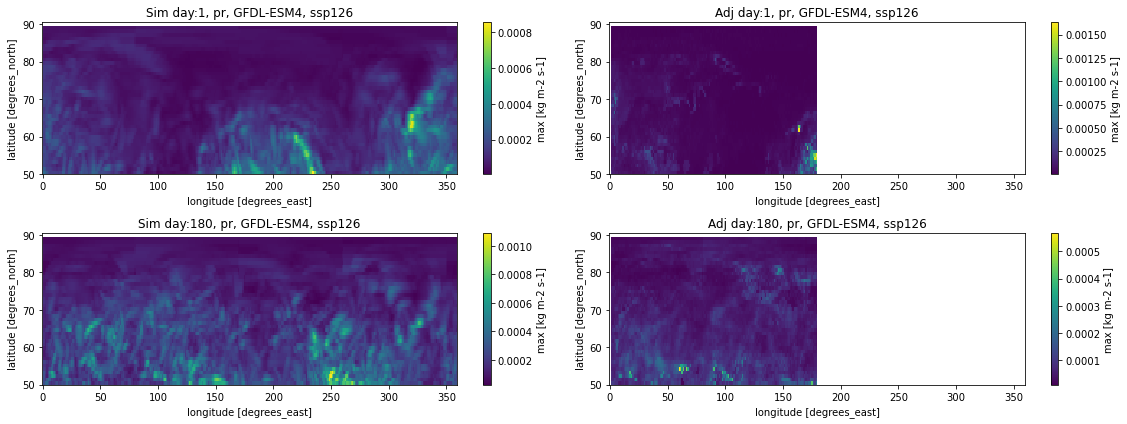

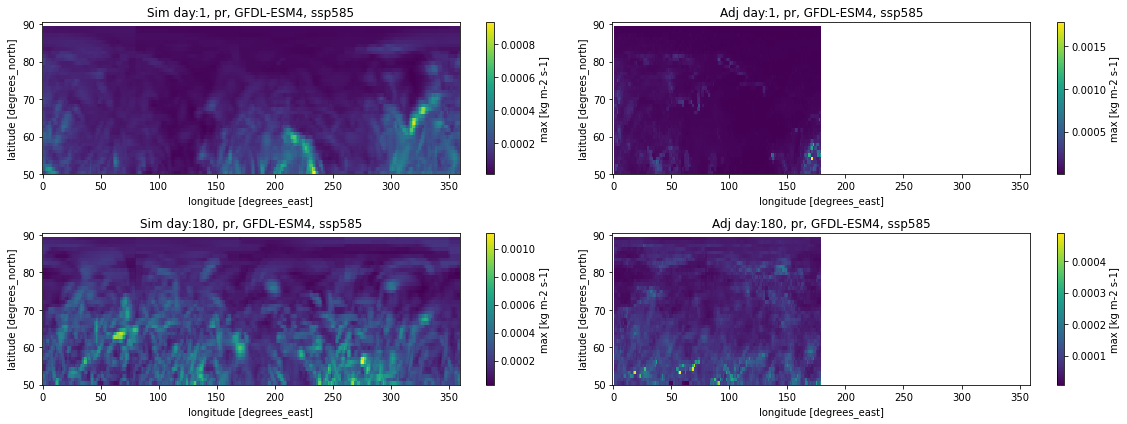

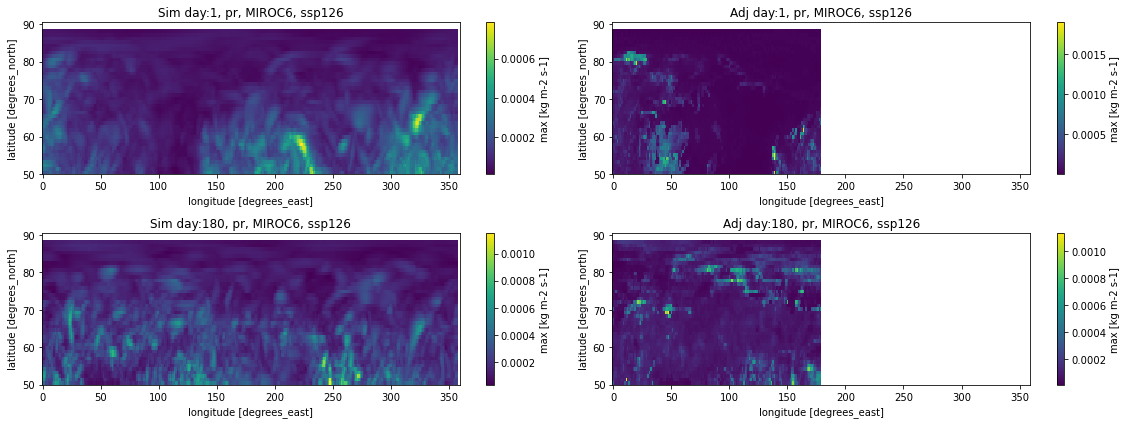

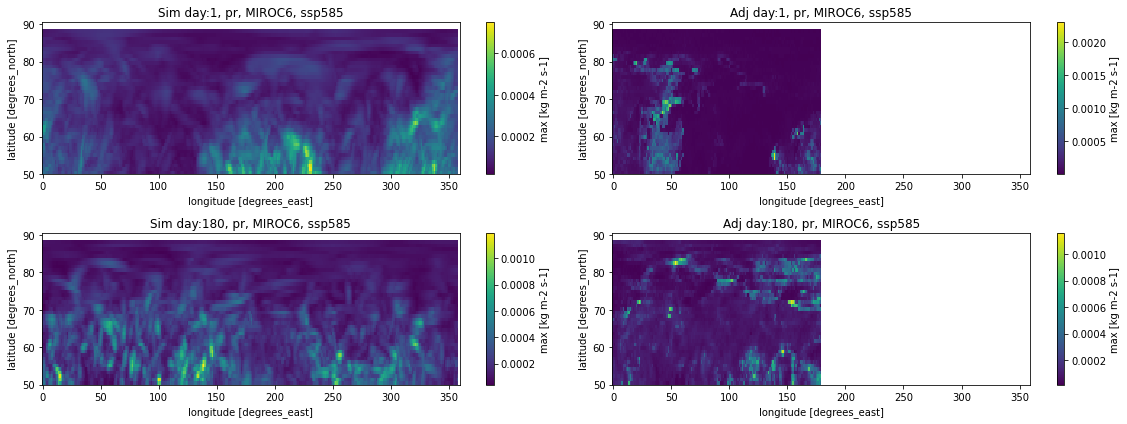

In [3]:
def doy_summary_maps(ds):
    for model in models:
        for scenario in scenarios:
            fig, ax = plt.subplots(2, 2, figsize=(16, 6))
            y_axis = 0
            for day_of_year in [1, 180]:
                lon_slice = slice(0, 360)
                lat_slice = slice(0, 90)

                params = {
                    "model": model,
                    "scenario": scenario,
                    "dayofyear": day_of_year,
                    "lat": lat_slice,
                    "lon": lon_slice,
                }

                sim_map = ds.sel(kind="sim", **params)["max"]
                adj_map = ds.sel(kind="adj", **params)["max"]

                sim_map.plot(ax=ax[y_axis][0])
                adj_map.plot(ax=ax[y_axis][1])

                ax[y_axis][0].set_title(f"Sim day:{day_of_year}, {var_id}, {model}, {scenario}")
                ax[y_axis][1].set_title(f"Adj day:{day_of_year}, {var_id}, {model}, {scenario}")

                y_axis += 1
            plt.tight_layout()

for var_id in var_ids:
    ds = xr.open_mfdataset(
        list(doy_summary_dir.glob(f"{var_id}_*.nc"))
    )
    doy_summary_maps(ds)

Note that the scale of the map legend / color ramp adjusts to the available data for each map and may not be the same. Take this into account when comparing the maps. As long the maps and color ramps look reasonable, we can proceed to drill down deeper into plot-based delta analysis.

## Max delta plots of min/mean/max for each day (DOY)

The next chunk of code will generate plots of the maximum deltas for each day-of-year for each of the statistic variables in the dataset (min, mean, max). Visualizing the deltas in this way will make it easier to detect if bias adjustment has gone too far. Reasonable delta values are dependent on the variable being analyzed. For example, if any of the min/mean/max deltas for the tasmax variable consistently exceeds 30 degrees Kelvin (i.e., a 30 degree difference between the unadjusted "sim" data and adjusted "adj" data), this might be considered an overcorrection worth investigating further.

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


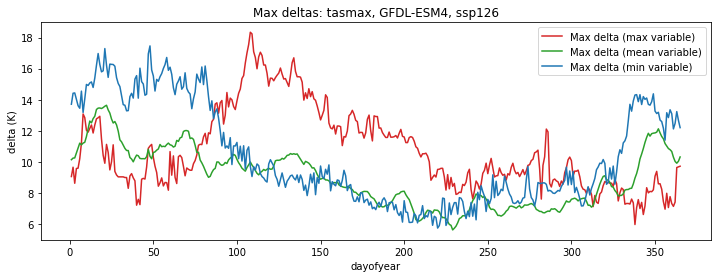

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


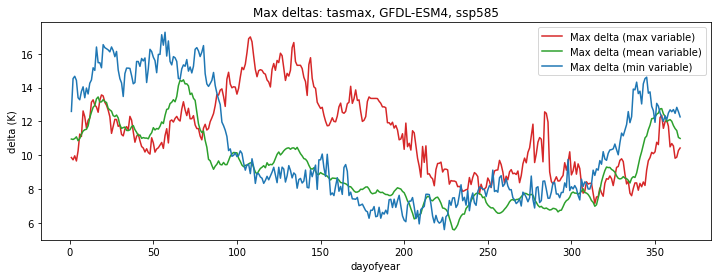

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


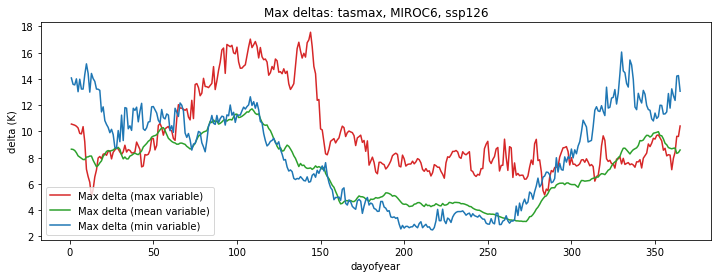

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


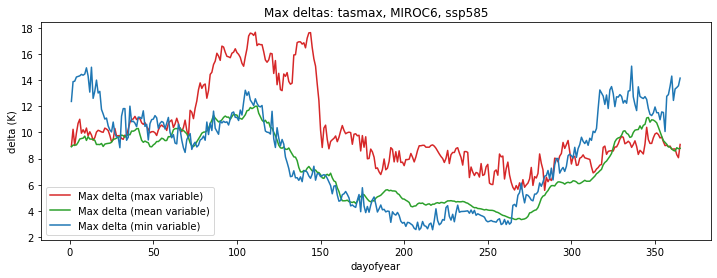

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


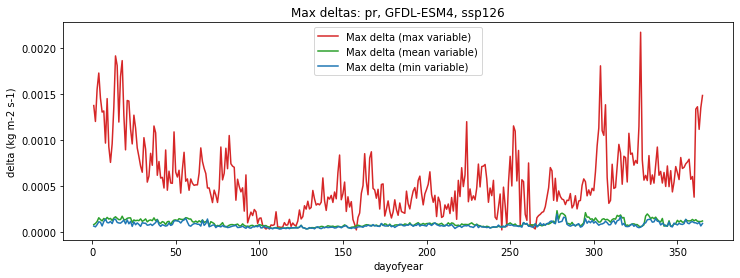

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


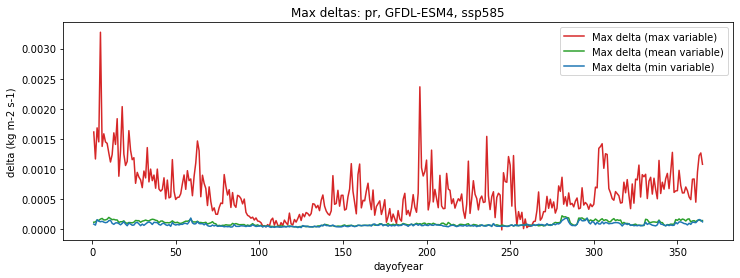

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


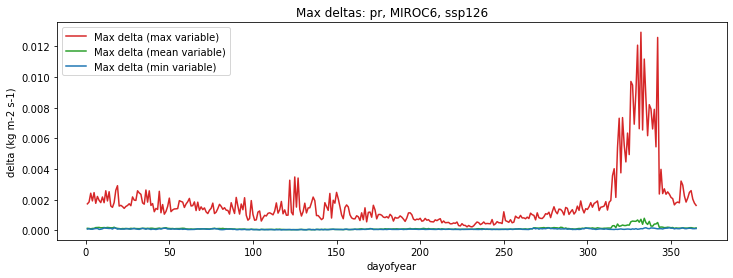

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


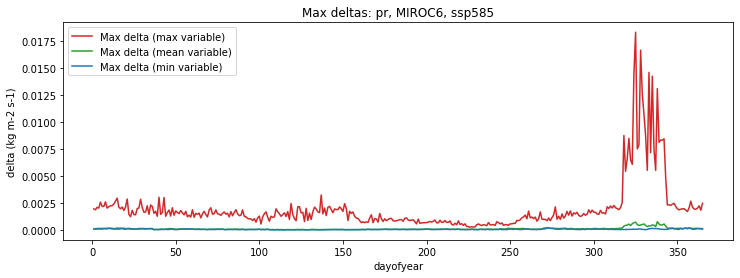

In [4]:
for var_id in var_ids:
    for model in models:
        ds = xr.open_mfdataset(
            list(doy_summary_dir.glob(f"{var_id}_{model}*.nc"))
        )
        delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")
        for scenario in scenarios:
            plt.figure(figsize=(12, 4))

            max_max_delta = delta_ds.sel(scenario=scenario)["max"].max(dim="lat").max(dim="lon")
            max_mean_delta = delta_ds.sel(scenario=scenario)["mean"].max(dim="lat").max(dim="lon")
            max_min_delta = delta_ds.sel(scenario=scenario)["min"].max(dim="lat").max(dim="lon")

            max_max_delta.plot(label="Max delta (max variable)", color="tab:red")
            max_mean_delta.plot(label="Max delta (mean variable)", color="tab:green")
            max_min_delta.plot(label="Max delta (min variable)", color="tab:blue")
    
            plt.title(f"Max deltas: {var_id}, {model}, {scenario}")
            plt.ylabel(f"delta ({units_lu[var_id]})")
            plt.legend()
            plt.show()

## Plots of sim vs. adj mean variable for a lat/lon point with a max delta

This next chunk of code will first find all lat/lon points that contain the maximum delta for the mean statistic variable. It will then choose one of these max-delta lat/lon points and generate a plot of the sim vs. adj data for that point to get a better sense of how the max delta affects the absolute (non-delta) values over time. In other words, these plots help answer the question "How extreme is the bias adjustment?" in absolute units that are easier to understand intuitively.

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


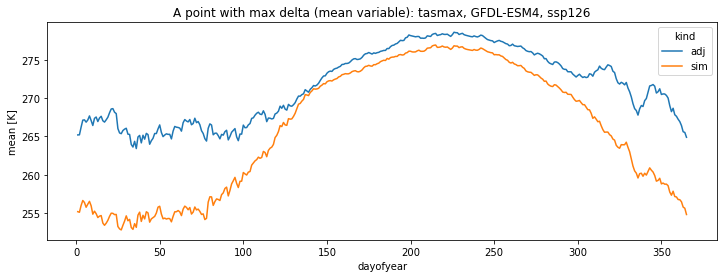

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


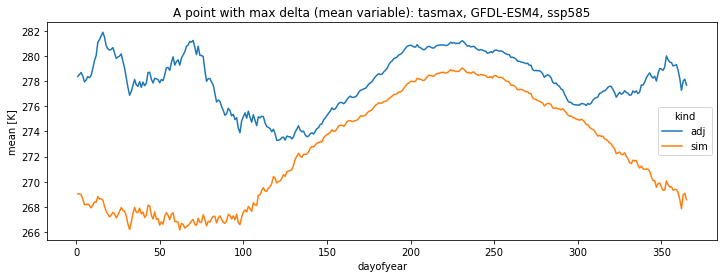

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


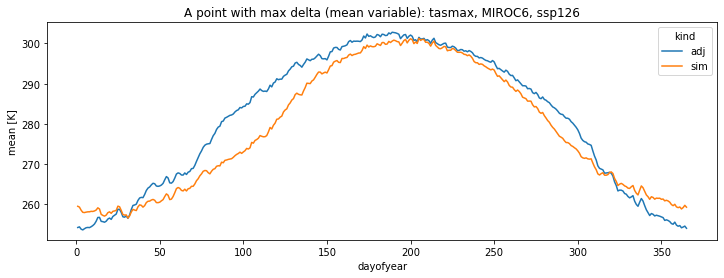

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


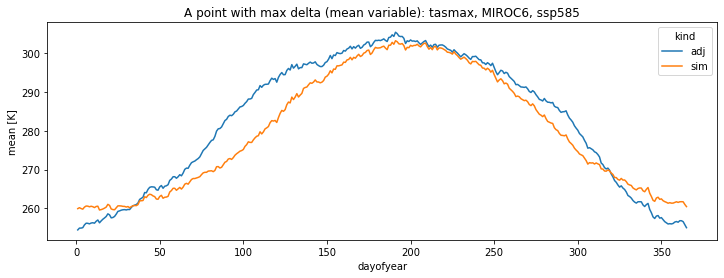

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


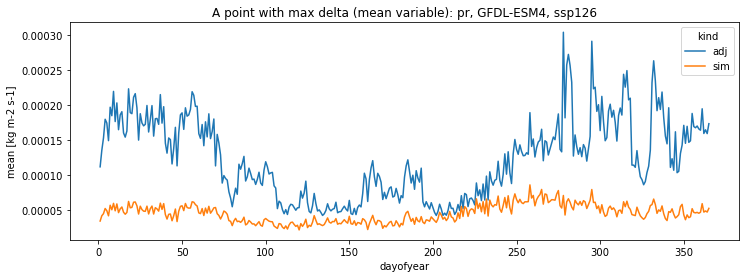

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


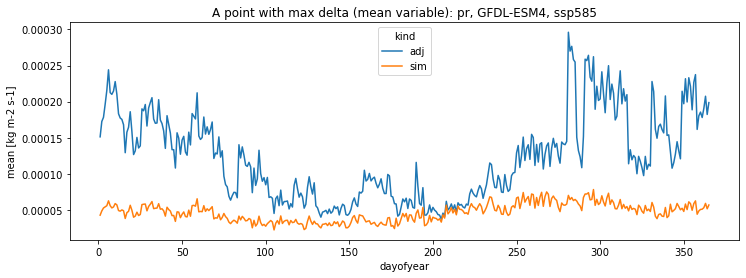

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


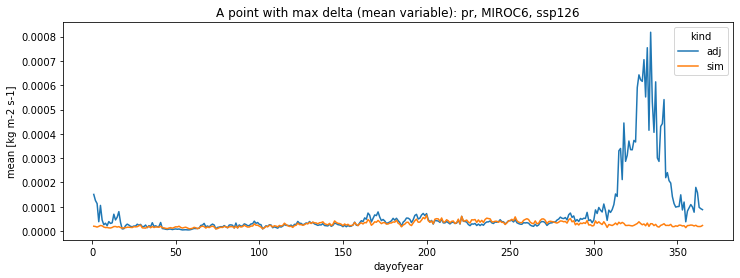

/home/crstephenson/miniconda3/envs/cmip6-utils/lib/python3.9/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


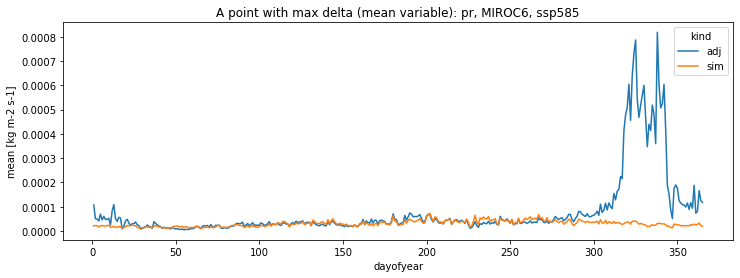

In [5]:
for var_id in var_ids:
    for model in models:
        ds = xr.open_mfdataset(
            list(doy_summary_dir.glob(f"{var_id}_{model}*.nc"))
        )

        for scenario in scenarios:
            delta_ds = ds.sel(kind="adj", scenario=scenario) - ds.sel(kind="sim", scenario=scenario)
            maximum_doy_deltas = delta_ds["mean"].max(dim="dayofyear").compute()
            max_delta_pixels = maximum_doy_deltas.where(
                maximum_doy_deltas == maximum_doy_deltas.max(), drop=True
            )
            max_delta_pixels
            bad_lat = max_delta_pixels.lat.values[0]
            bad_lon = max_delta_pixels.lon.values[0]

            plt.figure(figsize=(12, 4))
            ds.sel(lat=bad_lat, lon=bad_lon, scenario=scenario)["mean"].plot(x="dayofyear", hue="kind")
            plt.title(f"A point with max delta (mean variable): {var_id}, {model}, {scenario}")
            plt.show()

## Plots of four random lat/lon points for ref vs. sim vs. adj

As a final sanity check, the next chunk of code will generate DOY plots of historical reference data (ERA5) vs. regridded (sim) data vs. bias-adjusted (adj) data. This will generate sets of plots for four different lat/lon points selected at random. Note that, if this notebook is analyzing multiple variable/model/scenario combos, the sets of plots may appear out of order because we are using Dask to divide this work and run it in parallel using multiple workers. Each plot is labeled with variable/model/scenario info to avoid confusion.

distributed.diskutils - INFO - Found stale lock file and directory '/import/beegfs/CMIP6/crstephenson/cmip6-utils/bias_adjust/dask-worker-space/worker-payosfza', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/beegfs/CMIP6/crstephenson/cmip6-utils/bias_adjust/dask-worker-space/worker-5gkis_z7', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/beegfs/CMIP6/crstephenson/cmip6-utils/bias_adjust/dask-worker-space/worker-eokbzk7k', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/beegfs/CMIP6/crstephenson/cmip6-utils/bias_adjust/dask-worker-space/worker-b0kox391', purging


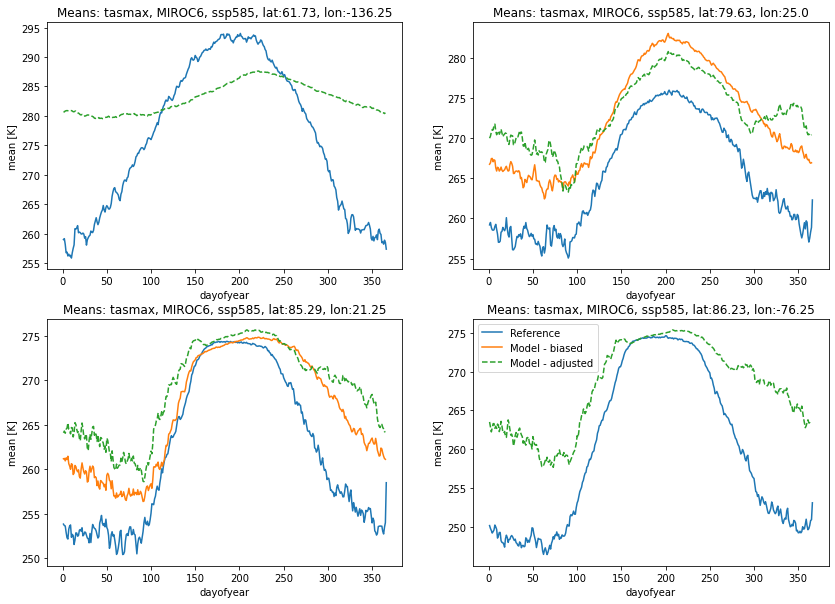

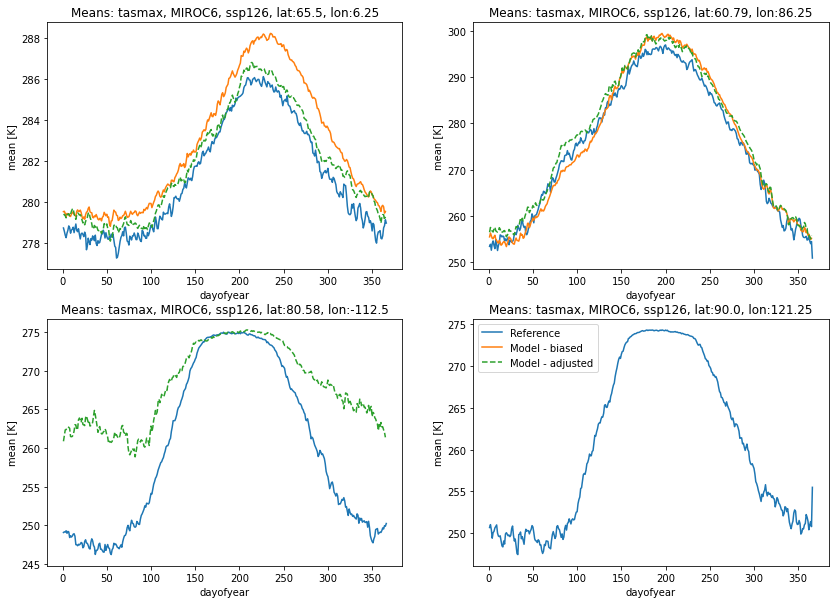

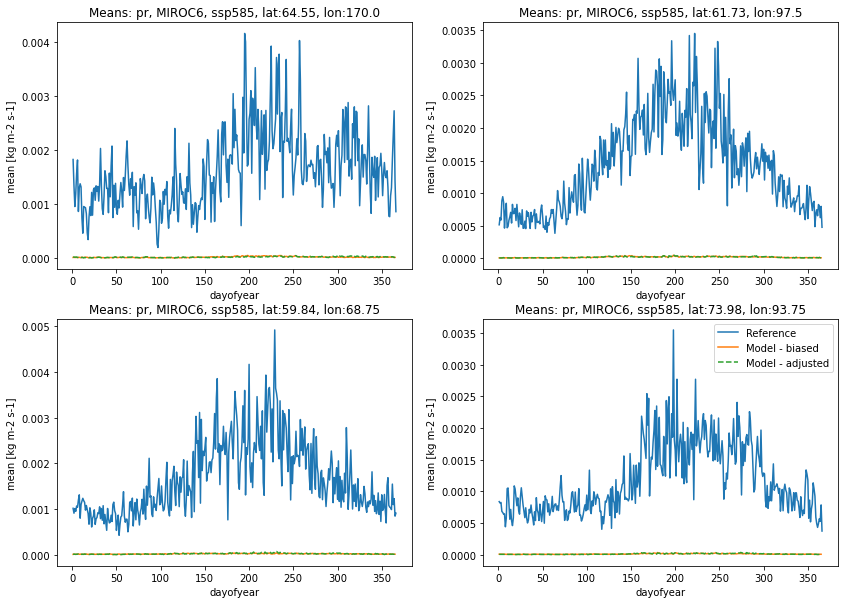

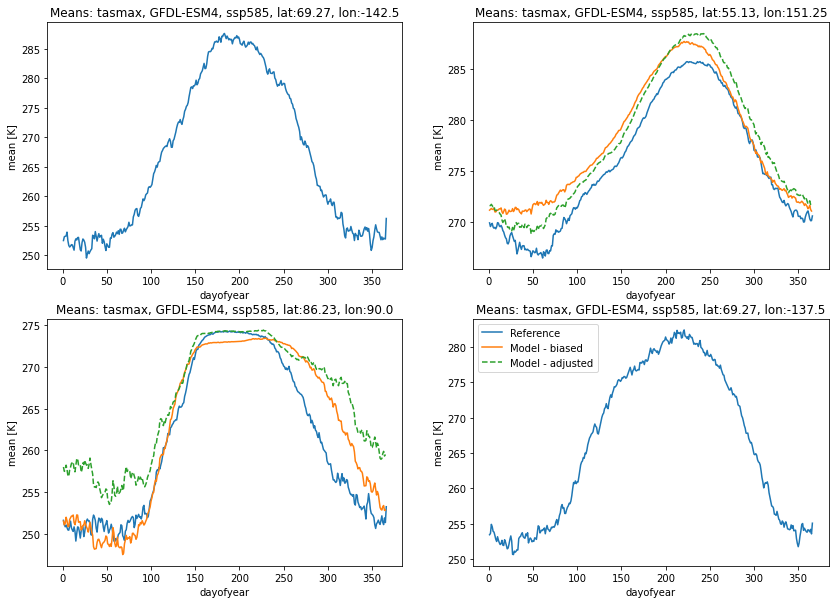

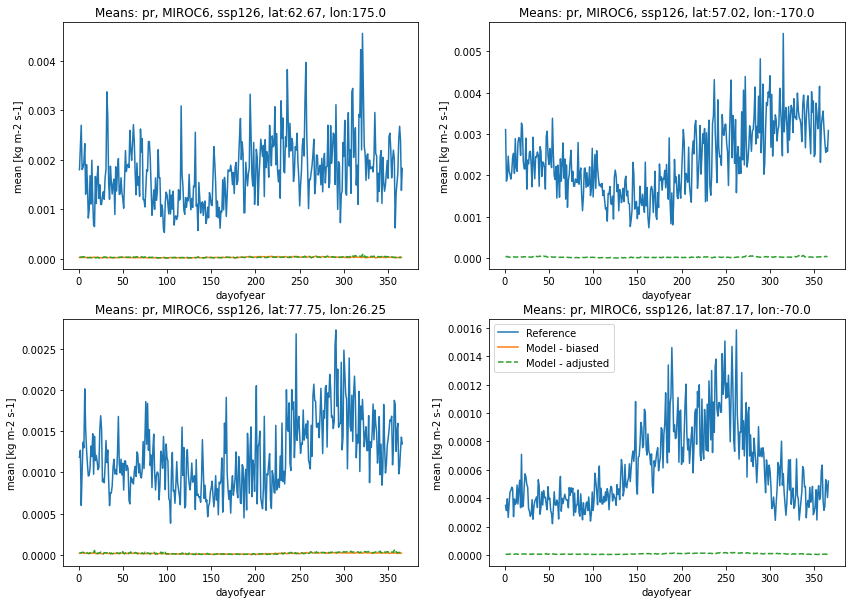

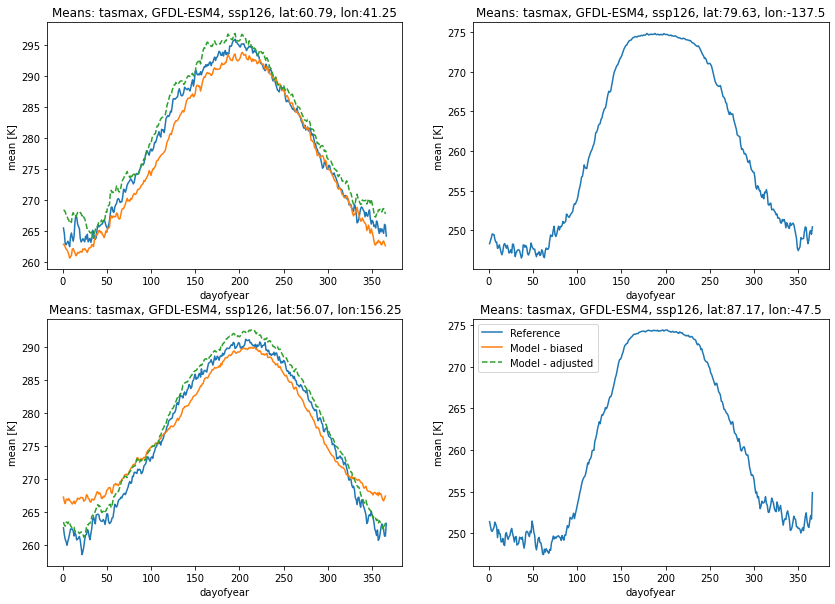

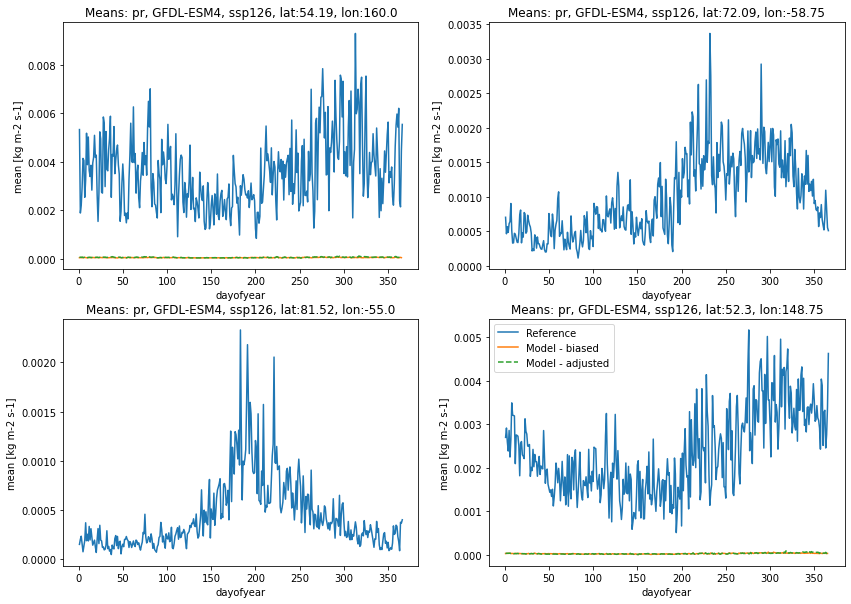

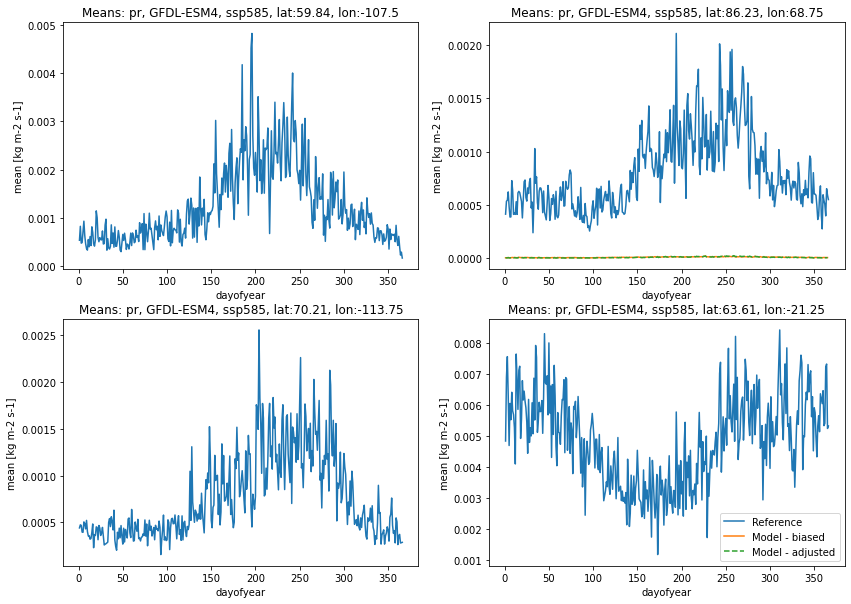

In [6]:
@dask.delayed
def plot_single_pixel_mean_doy(
    var_id,
    model,
    scenario
):
    ds = xr.open_mfdataset(
        list(doy_summary_dir.glob(f"{var_id}_{model}*.nc"))
    )

    ref_var_id = sim_ref_var_lu[var_id]
    ref_fps = [
        ref_dir.joinpath(ref_var_id, ref_tmp_fn.format(ref_var_id=ref_var_id, year=year))
        for year in ref_years
    ]

    ref_ds = xr.open_mfdataset(ref_fps)

    # ERA5 data uses expver=1, ERA5T uses expver=5.
    # So, use expver=1 if expver dimension is present in the reference dataset.
    if "expver" in ref_ds.coords:
        ref_ds = ref_ds.sel(expver=1)

    # get doy means
    ref_doy_mean = ref_ds[ref_var_id].groupby("time.dayofyear").mean()
    sim_doy_mean = ds.sel(kind="sim", var_id=var_id, model=model, scenario=scenario)["mean"]
    adj_doy_mean = ds.sel(kind="adj", var_id=var_id, model=model, scenario=scenario)["mean"]

    # Throw out all the pixels in adj_doy_mean that are between -180.0 and 0 degrees.
    adj_doy_mean = adj_doy_mean.where((adj_doy_mean.lon >= 0) & (adj_doy_mean.lon <= 360), drop=True)

    # pick a random pixel within the domain
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    for ax in axs.flatten():
        lat = round(np.random.choice(ref_ds.lat.values), 2)
        lon = round(np.random.choice(ref_ds.lon.values), 2)

        ref_mean_at_point = ref_doy_mean.sel(lat=lat, lon=lon, method='nearest')
        sim_mean_at_point = sim_doy_mean.sel(lat=lat, lon=lon, method='nearest')
        adj_mean_at_point = adj_doy_mean.sel(lat=lat, lon=lon, method='nearest')

        ref_mean_at_point.plot(x='dayofyear', label="Reference", ax=ax)
        sim_mean_at_point.plot(x='dayofyear', label="Model - biased", ax=ax)
        adj_mean_at_point.plot(x='dayofyear', label="Model - adjusted", ax=ax, linestyle="--")

        ax.set_title(f"Means: {var_id}, {model}, {scenario}, lat:{lat}, lon:{lon}")

    plt.legend()
    plt.show(block=False)

dask_tasks = []
for var_id in var_ids:
    for model in models:
        for scenario in scenarios:
            dask_tasks.append(plot_single_pixel_mean_doy(var_id, model, scenario))

client = Client(n_workers=4, memory_limit="8GB")

# Running this with any scheduler other than "synchronous" will cause errors or the plots to not show.
# We are probably not benefitting from Dask in any meaningful way because of this, but leaving this
# as-is for now so we can experiment with more Dask options in the future.
results = dask.compute(dask_tasks, scheduler="synchronous")